In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

In [3]:
df = pd.read_csv('../data/data_cleaned.csv')

In [4]:
df

,index,tag,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv,SMILES_GDB9,SMILES_relaxed
0,1,gdb,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,C,C
1,2,gdb,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316,N,N
2,3,gdb,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002,O,O
3,4,gdb,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,C#C,C#C
4,5,gdb,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278,C#N,C#N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133880,133881,gdb,3.59483,2.198990,1.904230,1.6637,69.37,-0.2254,0.0588,0.2842,760.7472,0.127406,-400.633868,-400.628599,-400.627654,-400.663098,23.658,C1C2C3C4C5OC14C5N23,C1[C@@H]2[C@@H]3[C@H]4[C@@H]5O[C@]14[C@@H]5N23
133881,133882,gdb,3.65648,2.142370,1.904390,1.2976,69.52,-0.2393,0.0608,0.3002,762.6354,0.127495,-400.629713,-400.624444,-400.623500,-400.658942,23.697,C1N2C3C2C2C4OC12C34,C1N2[C@H]3[C@@H]2[C@@H]2[C@H]4O[C@@]12[C@@H]34
133882,133883,gdb,3.67118,2.143140,1.895010,1.2480,73.60,-0.2233,0.0720,0.2953,780.3553,0.140458,-380.753918,-380.748619,-380.747675,-380.783148,23.972,C1N2C3C4C5C2C13CN45,C1N2[C@@H]3[C@@H]4[C@@H]5[C@H]2[C@]13CN45
133883,133884,gdb,3.52845,2.151310,1.865820,1.9576,77.40,-0.2122,0.0881,0.3003,803.1904,0.152222,-364.720374,-364.714974,-364.714030,-364.749650,24.796,C1N2C3C4C5CC13C2C45,C1N2[C@H]3[C@@H]4[C@@H]5C[C@]13[C@H]2[C@H]45


In [5]:
df.columns

Index(['index', 'tag', 'A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap',
       'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv', 'SMILES_GDB9',
       'SMILES_relaxed'],
      dtype='object')

## Define features

These classes are meant to define the types of atom and bond that are present in a molecule.
https://keras.io/examples/graph/mpnn-molecular-graphs/

In [6]:
class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()


atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},})

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},})

## Define graphs

Here, these functions are used to convert smiles to molecules and molecules to graph.
https://keras.io/examples/graph/mpnn-molecular-graphs/

In [7]:
def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule


def graph_from_molecule(molecule):
    # Initialize graph
    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # Add self-loops
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)


def graphs_from_smiles(smiles_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Convert lists to ragged tensors for tf.data.Dataset later on
    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),)


Next, locate molecules that can't be converted from smile.

In [8]:
bad_mol = []
for i in df.SMILES_relaxed:
    try:
        molecule_from_smiles(i)
    except:
        bad_mol.append(i)

In [9]:
df = df[~df['SMILES_relaxed'].isin(bad_mol)]

Define X and y, and split data

In [10]:
X = df['SMILES_relaxed']
y = df.drop(columns=['index','tag','A','B','C','SMILES_GDB9','SMILES_relaxed'])

In [11]:
X_nontest, X_test, y_nontest, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_nontest, y_nontest, test_size=0.20, random_state=42)

In [13]:
X_train.shape, y_train.shape

((85660,), (85660, 12))

In [14]:
X_val.shape, y_val.shape

((21416,), (21416, 12))

In [15]:
X_test.shape, y_test.shape

((26769,), (26769, 12))

Take a glance at a molecule.

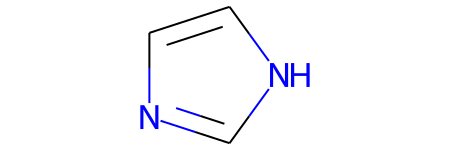

In [16]:
molecule = molecule_from_smiles(df.iloc[50].SMILES_relaxed)
molecule

In [17]:
graph = graph_from_molecule(molecule)
print("Graph (including self-loops):")
print("\tatom features\t", graph[0].shape)
print("\tbond features\t", graph[1].shape)
print("\tpair indices\t", graph[2].shape)

Graph (including self-loops):
	atom features	 (5, 29)
	bond features	 (15, 7)
	pair indices	 (15, 2)


Scale y values to improve stability and performance, check distributions

In [18]:
scaler = StandardScaler()
scaler.fit(y_train)
y_train = pd.DataFrame(scaler.transform(y_train), columns=y_train.columns)
y_val = pd.DataFrame(scaler.transform(y_val), columns=y_val.columns)

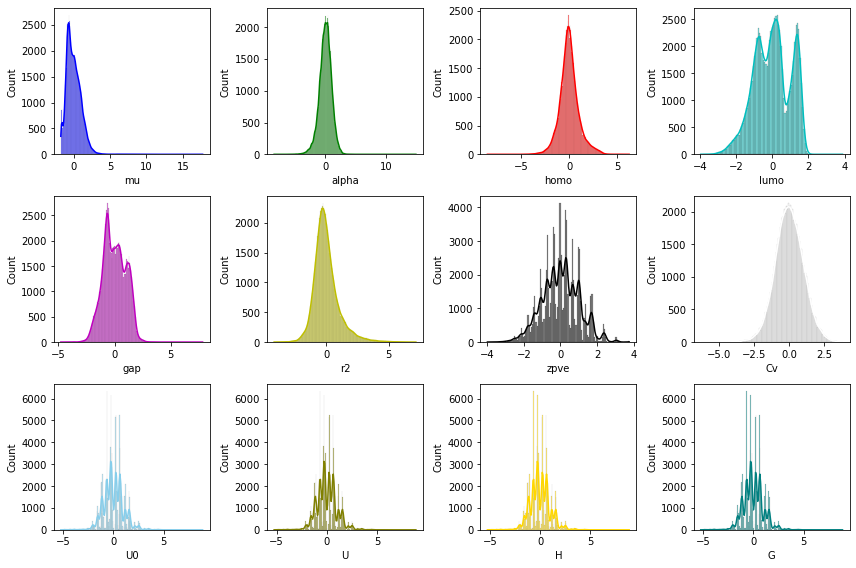

In [19]:
fig, axs = plt.subplots(3, 4, figsize=(12, 8))

sns.histplot(data=y_train, x="mu", kde=True, color="b", ax=axs[0, 0])
sns.histplot(data=y_train, x="alpha", kde=True, color="g", ax=axs[0, 1])
sns.histplot(data=y_train, x="homo", kde=True, color="r", ax=axs[0, 2])
sns.histplot(data=y_train, x="lumo", kde=True, color="c", ax=axs[0, 3])

sns.histplot(data=y_train, x="gap", kde=True, color="m", ax=axs[1, 0])
sns.histplot(data=y_train, x="r2", kde=True, color="y", ax=axs[1, 1])
sns.histplot(data=y_train, x="zpve", kde=True, color="k", ax=axs[1, 2])
sns.histplot(data=y_train, x="Cv", kde=True, color="w", ax=axs[1, 3])

sns.histplot(data=y_train, x="U0", kde=True, color="skyblue", ax=axs[2, 0])
sns.histplot(data=y_train, x="U", kde=True, color="olive", ax=axs[2, 1])
sns.histplot(data=y_train, x="H", kde=True, color="gold", ax=axs[2, 2])
sns.histplot(data=y_train, x="G", kde=True, color="teal", ax=axs[2, 3])

plt.tight_layout()

Create graphs from smiles

In [20]:
X_train_graph = graphs_from_smiles(X_train)
X_val_graph = graphs_from_smiles(X_val)
X_test_graph = graphs_from_smiles(X_test)

2022-02-24 21:26:24.407398: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Merge graphs

Make global graph where it is a disconnected graph. The subgraph is completely separated from the other subgraphs.
https://keras.io/examples/graph/mpnn-molecular-graphs/

In [21]:
def prepare_batch(x_batch, y_batch):
    """Merges (sub)graphs of batch into a single global (disconnected) graph
    """

    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices (molecule_indicator), which will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch


def MPNNDataset(X, y, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)

In [22]:
train_dataset = MPNNDataset(X_train_graph, y_train)
valid_dataset = MPNNDataset(X_val_graph, y_val)
test_dataset = MPNNDataset(X_test_graph, y_test)

## Define MPNN

In [23]:
class EdgeNetwork(layers.Layer):
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",)
        
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), initializer="zeros", name="bias",)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Apply linear transformation to bond features
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias

        # Reshape for neighborhood aggregation later
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        # Obtain atom features of neighbors
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)

        # Apply neighborhood aggregation
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],)
        return aggregated_features


class MessagePassing(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Pad atom features if number of desired units exceeds atom_features dim.
        # Alternatively, a dense layer could be used here.
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Perform a number of steps of message passing
        for i in range(self.steps):
            # Aggregate information from neighbors
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices])

            # Update node state via a step of GRU
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated)
        return atom_features_updated

In [24]:
class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):

        atom_features, molecule_indicator = inputs

        # Obtain subgraphs
        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )

        # Pad and stack subgraphs
        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],axis=0,)

        # Remove empty subgraphs (usually for last batch in dataset)
        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis=-1)
        return tf.gather(atom_features_stacked, gather_indices, axis=0)


class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self, num_heads=8, embed_dim=64, dense_dim=512, batch_size=32, **kwargs):
        super().__init__(**kwargs)

        self.partition_padding = PartitionPadding(batch_size)
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.average_pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs):
        x = self.partition_padding(inputs)
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]
        attention_output = self.attention(x, x, attention_mask=padding_mask)
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.average_pooling(proj_output)

In [25]:
def MPNNModel(atom_dim,bond_dim,batch_size=32,message_units=64,message_steps=4,num_attention_heads=8,dense_units=128,):

    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices])

    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size)([x, molecule_indicator])

    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dense(12)(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x],)
    return model

## Compile model and start training

In [26]:
mpnn = MPNNModel(atom_dim=X_train_graph[0][0][0].shape[0], bond_dim=X_train_graph[1][0][0].shape[0],)

mpnn.compile(
    loss='mse',
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[tf.keras.metrics.MeanSquaredError()],)

keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [27]:
mpnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 atom_features (InputLayer)     [(None, 29)]         0           []                               
                                                                                                  
 bond_features (InputLayer)     [(None, 7)]          0           []                               
                                                                                                  
 pair_indices (InputLayer)      [(None, 2)]          0           []                               
                                                                                                  
 message_passing (MessagePassin  (None, 64)          57728       ['atom_features[0][0]',          
 g)                                                               'bond_features[0][0]',      

In [28]:
history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=50,
    verbose=2,)

Epoch 1/50
2677/2677 - 326s - loss: 0.1247 - mean_squared_error: 0.1247 - val_loss: 0.0847 - val_mean_squared_error: 0.0847 - 326s/epoch - 122ms/step
Epoch 2/50
2677/2677 - 320s - loss: 0.0710 - mean_squared_error: 0.0710 - val_loss: 0.0689 - val_mean_squared_error: 0.0689 - 320s/epoch - 119ms/step
Epoch 3/50
2677/2677 - 319s - loss: 0.0602 - mean_squared_error: 0.0602 - val_loss: 0.0642 - val_mean_squared_error: 0.0642 - 319s/epoch - 119ms/step
Epoch 4/50
2677/2677 - 320s - loss: 0.0536 - mean_squared_error: 0.0536 - val_loss: 0.0567 - val_mean_squared_error: 0.0567 - 320s/epoch - 120ms/step
Epoch 5/50
2677/2677 - 321s - loss: 0.0490 - mean_squared_error: 0.0490 - val_loss: 0.0503 - val_mean_squared_error: 0.0503 - 321s/epoch - 120ms/step
Epoch 6/50
2677/2677 - 324s - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0456 - val_mean_squared_error: 0.0456 - 324s/epoch - 121ms/step
Epoch 7/50
2677/2677 - 322s - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0430 - val_mea

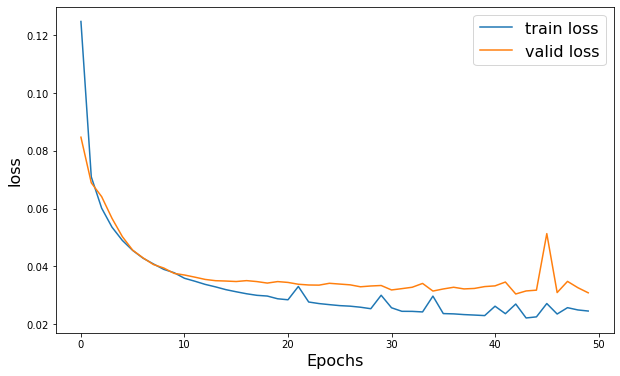

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="valid loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.legend(fontsize=16)

In [30]:
mpnn.save('../model/mymodel-3')

2022-02-25 01:59:38.590354: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../model/mymodel-3/assets


INFO:tensorflow:Assets written to: ../model/mymodel-3/assets


Make predictions on test set

In [31]:
#mpnn = tf.keras.models.load_model('../model/mymodel-3')

In [32]:
columns = ['mu', 'alpha', 'homo', 'lumo', 'gap','r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv']
y_pred = mpnn.predict(test_dataset)
y_pred = scaler.inverse_transform(y_pred)
y_pred = pd.DataFrame(y_pred, columns=columns)

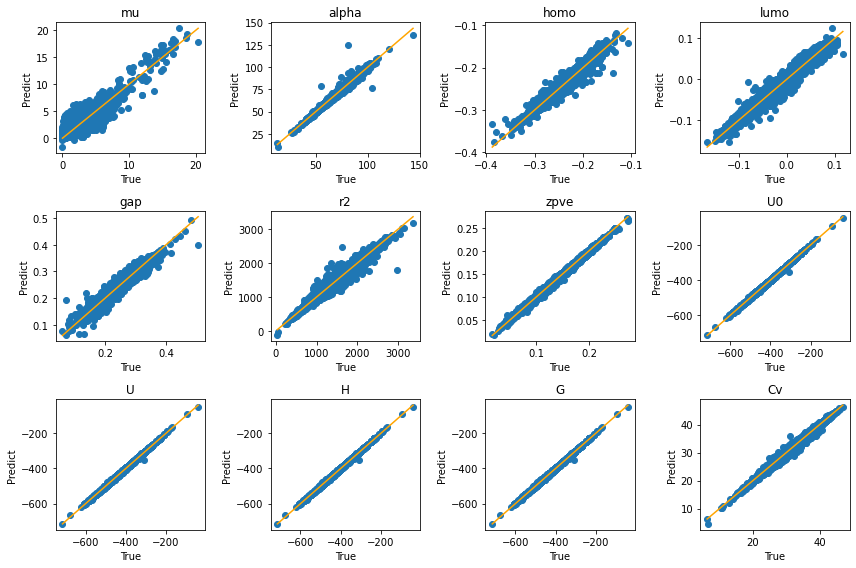

In [33]:
fig, axs = plt.subplots(3, 4, figsize=(12, 8))
myx = 0
myy = 0
for name in columns:
    axs[myx,myy].scatter(y_test[name], y_pred[name])
    axs[myx,myy].plot([min(y_test[name]),max(y_test[name])],[min(y_test[name]),max(y_test[name])],c='orange')
    axs[myx,myy].set_xlabel('True')
    axs[myx,myy].set_ylabel('Predict')
    axs[myx,myy].set_title(name)
    
    myy += 1
    if myy == 4:
        myy = 0
        myx += 1
        
plt.tight_layout()

In [34]:
print('property, rmse, r2')
for name in columns:
    print(name,mean_squared_error(y_test[name], y_pred[name], squared=False),r2_score(y_test[name], y_pred[name]))

property, rmse, r2
mu 0.6767462149361683 0.8045294240237149
alpha 0.8645158025880347 0.9888478094129644
homo 0.005326568636212404 0.943050239889689
lumo 0.006161652693230792 0.9827951763249156
gap 0.007889058996343512 0.9725487330033898
r2 52.19428330014251 0.9652574876452533
zpve 0.0018542006628393698 0.9968985875192878
U0 1.1451909241293188 0.9991866728220187
U 1.144832126217447 0.999187173320354
H 1.1438306043626947 0.9991885948522156
G 1.14250400930915 0.9991905055341783
Cv 0.4092189738638442 0.9898814942135596
